## 概要


```
@作者: 阿凯爱玩机器人
@QQ: 244561792
@微信: xingshunkai
@邮箱: xingshunkai@qq.com
@网址: deepsenserobot.com
@B站: "阿凯爱玩机器人"
```






## 配置文件 

In [1]:
# 是否从文件中载入图片
load_from_file = True
# TODO

## 导入依赖

In [2]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import open3d as o3d

# 自定义库
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.open3d import *
from kyle_robot_toolbox.open3d.o3d_utils import adjust_board_pose_by_pcd
from kyle_robot_toolbox.camera_calibration import CameraCalibration, CaliboardPose

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

pybullet build time: Jun  3 2022 02:05:55


## 创建相机对象 + 标定对象 + 标定板对象

In [3]:
# 创建相机对象
camera = Gemini335()
# 获取标定板信息
calibration = CameraCalibration(config_path=os.path.join("config",  "caliboard.yaml"), \
                                is_calibrate=False)
# 创建标定板可视化
caliboard_pose = CaliboardPose(camera, calibration)

## 拍摄图像 / 从文件中载入 
将标定板放到工作台的中心区域

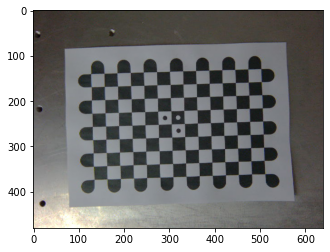

In [4]:
if load_from_file:
    # 从文件中载入彩图
    # 从文件中载入深度图
    img_name = "radon" # 图像ID
    color_image = cv2.imread(f"./data/example/radon_caliboard_pose_rgb/{img_name}.png")
    # 保存深度图 二进制格式
    depth_image = np.load(f"./data/example/radon_caliboard_pose_rgb/{img_name}.npy")
else:
    # 获取彩图与深度图
    color_image, depth_image = camera.read()

plt.imshow(color_image[:, :, ::-1])

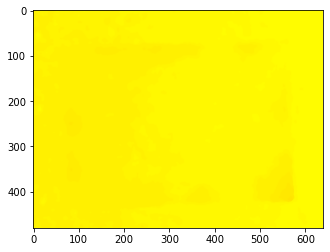

In [5]:
depth_canvas = camera.depth_img2canvas(depth_image, min_distance=150, max_distance=600)
plt.imshow(depth_canvas)

In [6]:
if not load_from_file:
    # 数据保存
    # 保存彩图
    img_name = "radon" # 图像ID
    cv2.imwrite(f"./data/example/radon_caliboard_pose_rgb/{img_name}.png", color_image)
    # 保存深度图 二进制格式
    np.save(f"./data/example/radon_caliboard_pose_rgb/{img_name}.npy", depth_image)
    cv2.imwrite(f"./data/example/radon_caliboard_pose_rgb/depth_canvas.png", depth_canvas)

## 移除畸变

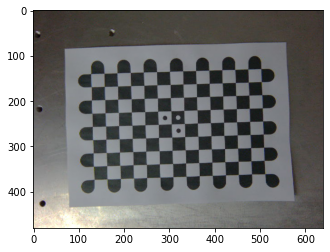

In [7]:
color_image_undistor =camera.remove_distortion(color_image)
plt.imshow(color_image_undistor[:, :, ::-1])

In [8]:
cv2.imwrite("./data/example/radon_caliboard_pose_rgb/color_image_undistor.png", color_image_undistor)

True

## 获取标定板在相机坐标系下的位姿

标定板在相机坐标系下的位姿
Pose x=-10.6 mm, y=9.5 mm, z=313.8 mm, roll=-179.5, pitch=0.5, yaw=178.2
标定板中心点在像素坐标系下的坐标
[305 251]


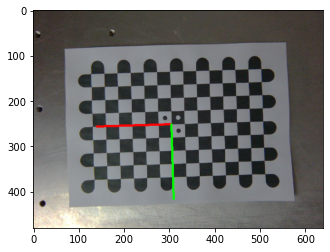

In [9]:
ret, pose_cam2board, center,  canvas = caliboard_pose.get_caliboard_pose(color_image_undistor)

print("标定板在相机坐标系下的位姿")
print(pose_cam2board)
print(f"标定板中心点在像素坐标系下的坐标")
print(center)

plt.imshow(canvas[:, :, ::-1])

In [10]:
cv2.imwrite("./data/example/radon_caliboard_pose_rgb/canvas.png", canvas)

True

In [12]:
# 获取变换矩阵T_cam2board
# 注:点云中点的坐标单位是m,因此需要注意单位。
T_cam2board = pose_cam2board.get_transform_matrix(unit="m")
print(f"标定板在相机坐标系下的变换矩阵T_cam2board: \n{T_cam2board}")

标定板在相机坐标系下的变换矩阵T_cam2board: 
[[-0.999  0.032  0.009 -0.011]
 [ 0.032  0.999 -0.009  0.01 ]
 [-0.009 -0.008 -1.     0.314]
 [ 0.     0.     0.     1.   ]]


## 生成点云

In [13]:
pcd = camera.get_pcd(color_image, depth_image, \
                                camera="rgb_camera")

## 纠正位姿

In [14]:
# 矫正姿态
T_cam2board2 = adjust_board_pose_by_pcd(T_cam2board, pcd)

In [15]:
# 显示标定板坐标系+点云
corrd_mesh_board = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
corrd_mesh_board.transform(T_cam2board2)
draw_geometry([pcd, corrd_mesh_board], window_name="点云+Radon标定板坐标系")

In [16]:
# 保存标定板坐标系在相机坐标系下的位姿
np.savetxt("./data/example/radon_caliboard_pose_rgb/T_cam2board.txt",T_cam2board2, delimiter=",")